## CMPE-272 Big Data
### Team #5


### Dataset information:
#### Name: Digital Music (reviews_Digital_Music.json)
#### Source: http://jmcauley.ucsd.edu/data/amazon/index.html
#### Sample schema:
```
{
  "reviewerID": "A2SUAM1J3GNN3B",
  "asin": "0000013714",
  "reviewerName": "J. McDonald",
  "helpful": [2, 3],
  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
  "overall": 5.0,
  "summary": "Heavenly Highway Hymns",
  "unixReviewTime": 1252800000,
  "reviewTime": "09 13, 2009"
}
```

In [1]:

import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': '4_r22NrNCwbJmK_Ldw0SidA6tJ2CBQMHwDb0ufQHXKa2',
    'service_id': 'iam-ServiceId-3999fa4b-f2fc-446e-a22a-b3049f3fde46',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_3f30c173f8f14d6faa1b70b233b44a49_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('reviews_Digital_Music_5.json', 'cmpe272bigdata-donotdelete-pr-ajvhabxitk4408'))
df_data_1 = df_data_1.withColumn("helpful_rating", df_data_1["helpful"].getItem(0)/ df_data_1["helpful"].getItem(1))
df_data_1.take(1)


Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20181010211930-0000


[Row(asin='5555991584', helpful=[3, 3], overall=5.0, reviewText='It\'s hard to believe "Memory of Trees" came out 11 years ago;it has held up well over the passage of time.It\'s Enya\'s last great album before the New Age/pop of "Amarantine" and "Day without rain." Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song."Memory of Trees" is elegaic&majestic.;"Pax Deorum" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a "disconcerting" blend of spirituality&sensuality;,I don\'t find it disconcerting at all."Anywhere is" is a hopeful song,looking to possibilities."Hope has a place" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I\'ve always had a soft spot for this song."On my way home" is a triumphant ending about return.This is truly a masterpiece of New Age music,a mu

#### Dataset count:

In [2]:
df_data_1.count()


64706

### Top 10 albums with the best raitings and the most helpful comments:

In [3]:
from pyspark.sql.functions import *

df_data_1.filter("overall = 5.0 and helpful_rating = 1.0") \
         .groupBy("asin") \
         .agg({"helpful_rating": "count"}) \
         .sort("count(helpful_rating)", ascending=False).take(10) \


[Row(asin='B000003AEK', count(helpful_rating)=69),
 Row(asin='B0000025RI', count(helpful_rating)=65),
 Row(asin='B000001A5X', count(helpful_rating)=62),
 Row(asin='B000002NJS', count(helpful_rating)=53),
 Row(asin='B000002OPL', count(helpful_rating)=50),
 Row(asin='B000001Y15', count(helpful_rating)=48),
 Row(asin='B00003002C', count(helpful_rating)=47),
 Row(asin='B00000163G', count(helpful_rating)=46),
 Row(asin='B000023VR6', count(helpful_rating)=45),
 Row(asin='B000002LGQ', count(helpful_rating)=43)]

### Overall distribution of review ratings with count

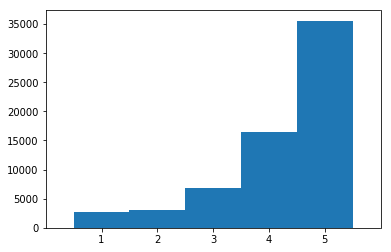

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Collects the Row objects, then the list comprehension extracts the float values as integers
overall_int = [int(x.overall) for x in df_data_1.select('overall').collect()]

# Plots data with a specific number of bins
plt.hist(overall_int,bins=np.arange(7)-0.5)
# This makes the x-axis plotting cleaner
plt.xticks(range(1,6))
plt.xlim([0,6])

# Show the data plot
plt.show()


### Top 5 best rated albums in year 2010

In [5]:
df_data_1.filter(df_data_1["reviewTime"].like('%2010')) \
         .filter("overall = 5.0 and helpful_rating = 1.0") \
         .groupBy("asin", "reviewTime") \
         .agg({"helpful_rating": "count"}) \
         .sort("count(helpful_rating)", ascending=False).take(5) \

[Row(asin='B003JYOFIW', reviewTime='06 15, 2010', count(helpful_rating)=3),
 Row(asin='B001MWGZDG', reviewTime='01 28, 2010', count(helpful_rating)=2),
 Row(asin='B0048LDTKK', reviewTime='12 14, 2010', count(helpful_rating)=2),
 Row(asin='B003JYOFIW', reviewTime='06 16, 2010', count(helpful_rating)=2),
 Row(asin='B0030NL8KK', reviewTime='03 5, 2010', count(helpful_rating)=2)]

### Reviews count for year 2005

In [6]:
df_data_1.filter(df_data_1["reviewTime"].like('%2005')).count()

8149

### Reviews done in year 2010

In [7]:
df_data_1.filter(df_data_1["reviewTime"].like('%2010')).count()

2187

### Count of reviews done by a particular user: Amaranth "music fan"

In [8]:
df_data_1.filter("reviewerID='A3EBHHCZO6V2A4' and reviewerName='Amaranth \"music fan\"'").count()

90

### Scatterplot of review length against helpfulness
#### Helpful ratings (>80% helpful) tend to have more reviews over 4000 char.

In [9]:
# Add a column to display length of review data
df_data_1 = df_data_1.withColumn("review_length", length(df_data_1["reviewText"]))
df_data_1.select('reviewText','review_length').take(1)

[Row(reviewText='It\'s hard to believe "Memory of Trees" came out 11 years ago;it has held up well over the passage of time.It\'s Enya\'s last great album before the New Age/pop of "Amarantine" and "Day without rain." Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song."Memory of Trees" is elegaic&majestic.;"Pax Deorum" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a "disconcerting" blend of spirituality&sensuality;,I don\'t find it disconcerting at all."Anywhere is" is a hopeful song,looking to possibilities."Hope has a place" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I\'ve always had a soft spot for this song."On my way home" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!', review_length=950)]

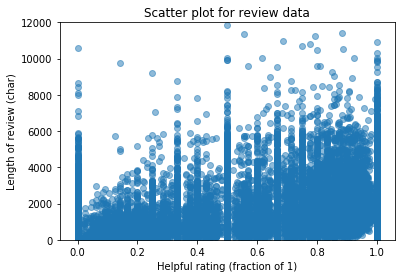

In [10]:
# Extract data from the columns, filter out any with no helpful ratings
x_data = [float(a.helpful_rating) for a in df_data_1.select('review_length','helpful_rating').dropna(how='any').collect()]
y_data = [int(b.review_length) for b in df_data_1.select('review_length','helpful_rating').dropna(how='any').collect()]

# Create a scatter plot of the data
plt.scatter(x_data, y_data, alpha = 0.5)
plt.title('Scatter plot for review data')
plt.xlabel('Helpful rating (fraction of 1)')
plt.ylabel('Length of review (char)')
# Filter insignificant outliers and make data easier to read
plt.ylim([0,12000])

plt.show()

### Top 10 reviwers:

In [43]:
from pyspark.sql.functions import *

names =   df_data_1.select("reviewerName") \
         .groupBy("reviewerName") \
         .agg({"reviewerName": "count"}) \
         .sort("count(reviewerName)", ascending=False).take(10) \

for n in names:
    print("Name:", n["reviewerName"], "Review counts: ", n["count(reviewerName)"])

Name: mistermaxxx08 "mistermaxxx08" Review counts:  575
Name: Andre S. Grindle "Andre' Grindle" Review counts:  375
Name: Tim Brough "author and music buff" Review counts:  301
Name: G$ "Z-Wad" Review counts:  261
Name: IRate Review counts:  256
Name: P Magnum Review counts:  246
Name: Anthony Rupert "shut up, Shut Up, SHUT UP!!!" Review counts:  199
Name: Enlightened "Both Eyes Closed, see what u don... Review counts:  195
Name: Paul Allaer Review counts:  191
Name: Michael Kerner "Michael Kerner" Review counts:  191


### Top 10 albums with links to Amazon:


In [19]:
from pyspark.sql.functions import *

results = df_data_1.select("asin") \
         .groupBy("asin") \
         .agg({"asin": "count"}) \
         .sort("count(asin)", ascending=False).take(10) \


for x in results:
    print("https://www.amazon.com/dp/" + x["asin"], "Review counts: ", x["count(asin)"])

https://www.amazon.com/dp/B0007NFL18 Review counts:  272
https://www.amazon.com/dp/B000084T18 Review counts:  271
https://www.amazon.com/dp/B00006690F Review counts:  204
https://www.amazon.com/dp/B00004T9UF Review counts:  202
https://www.amazon.com/dp/B00005YW4H Review counts:  190
https://www.amazon.com/dp/B0006ZQ9BS Review counts:  185
https://www.amazon.com/dp/B0000AGWFX Review counts:  181
https://www.amazon.com/dp/B00005O54Q Review counts:  169
https://www.amazon.com/dp/B00000163G Review counts:  166
https://www.amazon.com/dp/B00065XJ52 Review counts:  159
